# NFL Punt Analytics Report

In an effort to crowdsource a solution for safer punt plays in the professional (American) football games, the National Football League (NFL) has created a Kaggle competition seeking a data-backed proposal for punt-play rule changes. This follows a season where kickoff rules were changed to reduce concussions suffered during such plays. The top 4 proposals in this competition will be asked to present at NFL First & Future in Atlanta the day before the Super Bowl.

## The Dataset

The dataset provided by the NFL for this competition is actually a robust set of smaller datasets collected from the 2016 and 2017 NFL seasons. There are CSV files for the following information: 

   - Game Data 
   - Play Info 
   - Player Punt Data (Each player's traditional position) 
   - Play Player Role Data (Player role during punt plays) 
   - Video Review (Detailed injury play data) 
   - Next Generation Statistics (Positional and temporal data for extrapolating player speed/acceleration)

The sum of these datasets is about 10 GB of data that can be concatenated on common columns such as Game Key, Play ID, and GSISID(PlayerID). Each file has cleanly-formatted, but the sum of this data is a bit much to keep on desktop memory in Pandas Data Frames to extract meaningful analysis in an efficient. Fortunately, the NFL also provided a summary of the columns in each dataset, their dtype, and a glimpse at them on the Kaggle site so we can begin to formulate means of answering questions from a subset of the data.

Still, it would be worthwhile to show what to expect in these datasets.

In [1]:
#Import the necessary libraries
from collections import Counter
import csv
from dateutil import parser
import glob
from io import StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import ttest_ind
import seaborn as sns
%matplotlib inline

In [4]:
#Set a for loop to iterate over each data file
for path in glob.glob('*.csv'):
    
#Use a with statement to ensure files close upon completion. Set a count variable and a column header empty list.
    with open(path) as f:
        count = 0
        columns = []
        
#Set up a reader to iterate over each row of the file. Append the first row to the column headers and keep track of count.
        rdr = csv.reader(f)
        for row in rdr:
            if count == 0:
                columns.append(row)
            count += 1
            
    print('Dataset: {}'.format(path))
    print('Record Count: {}'.format(count))
    print('Column Headers: {}\n'.format(columns))

Dataset: video_footage-injury.csv
Record Count: 38
Column Headers: [['season', 'Type', 'Week', 'Home_team', 'Visit_Team', 'Qtr', 'PlayDescription', 'gamekey', 'playid', 'PREVIEW LINK (5000K)']]

Dataset: NGS-2016-reg-wk13-17.csv
Record Count: 7611810
Column Headers: [['Season_Year', 'GameKey', 'PlayID', 'GSISID', 'Time', 'x', 'y', 'dis', 'o', 'dir', 'Event']]

Dataset: NGS-2017-reg-wk1-6.csv
Record Count: 9433923
Column Headers: [['Season_Year', 'GameKey', 'PlayID', 'GSISID', 'Time', 'x', 'y', 'dis', 'o', 'dir', 'Event']]

Dataset: NGS-2017-post.csv
Record Count: 1037159
Column Headers: [['Season_Year', 'GameKey', 'PlayID', 'GSISID', 'Time', 'x', 'y', 'dis', 'o', 'dir', 'Event']]

Dataset: NGS-2017-reg-wk7-12.csv
Record Count: 8670289
Column Headers: [['Season_Year', 'GameKey', 'PlayID', 'GSISID', 'Time', 'x', 'y', 'dis', 'o', 'dir', 'Event']]

Dataset: video_footage-control.csv
Record Count: 38
Column Headers: [['season', 'Season_Type', 'Week', 'Home_team', 'Visit_Team', 'Qtr', 'PlayD

From this preview of the files I gained two important insights:

- The NGS files are too big to hold in memory as Pandas data frames
- Any merges performed with the video footage files will requires changing the column headers 'gamekey' and 'playid' to 'GameKey' and 'PlayID'

## Question 1: Do weather, stadium/turf type, and temperature play a significant factor?

In an attempt isolate variables that may correlate with increased injury, I would like to start with this question. I can use the entries in Video Review as indicators of injury inducing plays, allowing a merger with game data for those games in which injury inducing plays occurred.

In [5]:
#Import game data as a Pandas Data Frame
gamedata_df = pd.read_csv('game_data.csv')

In [6]:
#Check unique values for weather
gamedata_df.GameWeather.unique()

array([nan, 'Sunny', 'Party Cloudy', 'Partly Cloudy, Chance of Rain 80%',
       'Partly Cloudy', 'T-Storms', 'Cloudy', 'Mostly Cloudy',
       'Hazy, hot and humid', 'Indoor', 'Clear and warm',
       'Controlled Climate', 'Suny', 'Chance of Showers',
       'Mostly Clear. Gusting ot 14.', 'Indoors', 'Mostly cloudy',
       'Cloudy with Possible Stray Showers/Thundershowers',
       'Mostly CLoudy', 'Clear', 'Partly sunny', 'Rain', 'Mostly Sunny',
       'Sunny and Clear', 'Partly CLoudy',
       'Cloudy, Humid, Chance of Rain', 'Sunny Intervals', 'Fair',
       'Controlled', 'Sunny Skies', 'Partly Sunny', 'Sunny intervals',
       'Clear Skies', 'Clear and cool', 'Cloudy with rain',
       'Snow Showers, 3 to 5 inches expected.', 'Sunny and cool',
       'Snow showers', 'Snow', 'Partly cloudy', 'Cloudy, steady temps',
       'Cloudy, Rain', 'Cloudy and Cold', 'Cloudy with patches of fog',
       'Scattered thunderstorms', 'Sunny and warm', 'cloudy',
       'Light Rain', 'Partly cloud

While much of the data was standardized, columns like GameWeather, Turf, and StadiumType have far too many values and non-standard inputs for what is essentially the same value. I will go through the process of reducing the number of values to something more manageable for visualization.

In [7]:
#Standardize and reduce the number of weather values

nw = {}
for value in gamedata_df.GameWeather.unique():
    s = str(value).lower()
    if 'snow' in s:
        nw[value] = 'snow'
    elif 'rain' in s or 'shower' in s and 'chance' not in s and 'possible' not in s:
        nw[value] = 'rain'
    elif 'cold' in s:
        nw[value] = 'cold'
    elif 'wind' in s or 'gust' in s:
        nw[value] = 'windy'
    elif 'sun' in s or 'clear' in s:
        nw[value] = 'pleasant'
    elif 'storm' in s:
        nw[value] = 'stormy'
    elif 'hot' in s:
        nw[value] = 'hot'
    elif 'fog' in s or 'haz' in s:
        nw[value] = 'fog/haze'
    elif 'indoor' in s or 'control' in s:
        nw[value] ='indoor'
    else:
        nw[value] = 'cloudy/mixed'
        
gamedata_df['GameWeather'].replace(nw.keys(), nw.values(), inplace=True)
gamedata_df['GameWeather'].value_counts()

cloudy/mixed    346
pleasant        226
indoor           46
rain             31
snow              6
cold              4
fog/haze          3
stormy            2
windy             1
hot               1
Name: GameWeather, dtype: int64

In [8]:
#Standardize and reduce number of turf values
nw = {}
for value in gamedata_df.Turf.unique():
    t = str(value).lower()
    if 'grass' in t or 'nat' in t:
        nw[value] = 'grass'
    elif 'turf' in t:
        nw[value] = 'turf'
    elif 'art' in t or 'syn' in t:
       nw[value] = 'artificial'
    elif 'ubu' in t:
        nw[value] = 'ubu_speed'
    else:
        nw[value] = 'other'
        
gamedata_df['Turf'].replace(nw.keys(), nw.values(), inplace=True)
gamedata_df['Turf'].value_counts()

grass         389
turf          151
artificial     65
ubu_speed      60
other           1
Name: Turf, dtype: int64

In [9]:
#Standardize and reduce number of Stadium Type values
nw = {}
for value in gamedata_df.StadiumType.unique():
    p = str(value).lower()
    if 'indoor' in p or 'dome' in p or 'close' in p or 'turf' in p:
        nw[value] = 'indoor/dome'
    else:
        nw[value] = 'outdoor/open'


gamedata_df['StadiumType'].replace(nw.keys(), nw.values(), inplace=True)
gamedata_df['StadiumType'].value_counts()

outdoor/open    526
indoor/dome     140
Name: StadiumType, dtype: int64

In [20]:
def num_category(df, col, name):
    ''' Assign a number based on unique string values within a column to use for histogram
    :param df: var, dataframe to operate on
    :param col: str, existing dataframe column to categorize
    :param name: str, name for new column with numerical categories'''
    unq = np.unique(df[col]) 
    df[name] = [list(unq).index(v) for v in df[col]]
    return df

,GameKey,Season_Year,Season_Type,Week,Game_Date,Game_Day,Game_Site,Start_Time,Home_Team,HomeTeamCode,Visit_Team,VisitTeamCode,Stadium,StadiumType,Turf,GameWeather,Temperature,OutdoorWeather,stadium
661,662,2017,Post,2,2018-01-14 00:00:00.000,Sunday,Minneapolis,15:40,Minnesota Vikings,MIN,New Orleans Saints,NO,U.S. Bank Stadium,indoor/dome,turf,indoor,NaN,NaN,0
662,663,2017,Post,3,2018-01-21 00:00:00.000,Sunday,Foxborough,15:05,New England Patriots,NE,Jacksonville Jaguars,JAX,Gillette Stadium,outdoor/open,turf,pleasant,48.0,NaN,1
663,664,2017,Post,3,2018-01-21 00:00:00.000,Sunday,Philadelphia,18:40,Philadelphia Eagles,PHI,Minnesota Vikings,MIN,Lincoln Financial Field,outdoor/open,grass,cloudy/mixed,47.0,Cloudy,1
664,665,2017,Post,4,2018-02-04 00:00:00.000,Sunday,Minneapolis,17:30,New England Patriots,NE,Philadelphia Eagles,PHI,U.S. Bank Stadium,indoor/dome,turf,cloudy/mixed,3.0,NaN,0
665,666,2017,Post,5,2018-01-28 00:00:00.000,Sunday,Orlando,15:00,AFC,AFC,NFC,NFC,Camping World Stadium,outdoor/open,turf,cloudy/mixed,77.0,Cloudy,1


In [21]:
num_category(gamedata_df, 'StadiumType', 'stadium')
num_category(gamedata_df, 'GameWeather', 'weather')
num_category(gamedata_df, 'Turf', 'turf')


,GameKey,Season_Year,Season_Type,Week,Game_Date,Game_Day,Game_Site,Start_Time,Home_Team,HomeTeamCode,...,VisitTeamCode,Stadium,StadiumType,Turf,GameWeather,Temperature,OutdoorWeather,stadium,weather,turf
0,1,2016,Pre,1,2016-08-07 00:00:00.000,Sunday,Indianapolis,20:00,Indianapolis Colts,IND,...,GB,Tom Benson Hall of Fame Stadium,outdoor/open,turf,cloudy/mixed,NaN,NaN,1,0,3
1,2,2016,Pre,2,2016-08-13 00:00:00.000,Saturday,Los Angeles,17:00,Los Angeles Rams,LA,...,DAL,Los Angeles Memorial Coliseum,outdoor/open,grass,pleasant,79.0,Sunny,1,5,1
2,3,2016,Pre,2,2016-08-11 00:00:00.000,Thursday,Baltimore,19:30,Baltimore Ravens,BLT,...,CAR,M&T Bank Stadium,outdoor/open,grass,cloudy/mixed,94.0,Partly Cloudy,1,0,1
3,4,2016,Pre,2,2016-08-12 00:00:00.000,Friday,Green Bay,19:00,Green Bay Packers,GB,...,CLV,Lambeau Field,outdoor/open,grass,cloudy/mixed,73.0,NaN,1,0,1
4,5,2016,Pre,2,2016-08-11 00:00:00.000,Thursday,Chicago,19:00,Chicago Bears,CHI,...,DEN,Soldier Field,outdoor/open,grass,rain,88.0,NaN,1,6,1
5,6,2016,Pre,2,2016-08-12 00:00:00.000,Friday,Pittsburgh,19:00,Pittsburgh Steelers,PIT,...,DET,Heinz Field,outdoor/open,grass,cloudy/mixed,82.0,Partly Cloudy,1,0,1
6,7,2016,Pre,2,2016-08-14 00:00:00.000,Sunday,Santa Clara,16:00,San Francisco 49ers,SF,...,HST,Levis Stadium,outdoor/open,grass,pleasant,84.0,NaN,1,5,1
7,8,2016,Pre,2,2016-08-13 00:00:00.000,Saturday,Orchard Park,19:00,Buffalo Bills,BUF,...,IND,Ralph Wilson Stadium,outdoor/open,turf,stormy,84.0,T-Storms increasing over 30 minutes before kic...,1,8,3
8,9,2016,Pre,2,2016-08-11 00:00:00.000,Thursday,East Rutherford,19:30,New York Jets,NYJ,...,JAX,MetLife,outdoor/open,turf,cloudy/mixed,94.0,Cloudy,1,0,3
9,10,2016,Pre,2,2016-08-12 00:00:00.000,Friday,East Rutherford,19:00,New York Giants,NYG,...,MIA,MetLife Stadium,outdoor/open,ubu_speed,cloudy/mixed,76.0,NaN,1,0,4


In [22]:
#Create a Data Frame of just injury producing games for comparison with all games
injury_games_df = pd.merge(gamedata_df, pd.read_csv('video_review.csv'), on=['GameKey', 'Season_Year'], how='inner')

In [32]:
def compare_hists(x1, x2, label1=None, label2=None, title1=None, title2=None, figsize=(10, 5)):
    '''Create a plot with subplots of histograms for comparison
    :param x: series or array-like, data to be plotted
    :param label: series or array-like, labels for the data'''
    plt.figure(figsize=figsize)
    
    plt.subplot(1, 2, 1)
    plt.hist(x1, label=label1)
    plt.title('2016/17 Punts by {}'.format(title1))
    
    plt.subplot(1, 2, 2)
    plt.hist(x2, label=label2)
    plt.title('2016/17 Punts by {}'.format(title2))
    return plt.show()
    

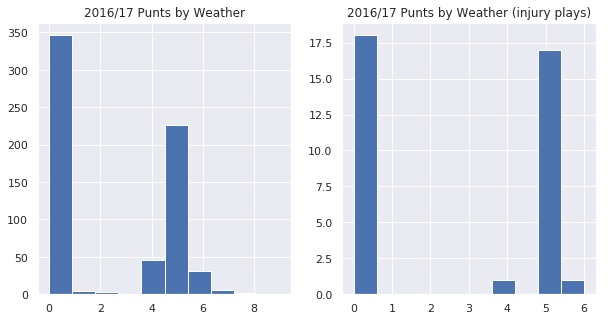

In [33]:
sns.set()
compare_hists(gamedata_df['weather'], injury_games_df['weather'], title1='Weather', title2='Weather (injury plays)')

/home/jeff/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jeff/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


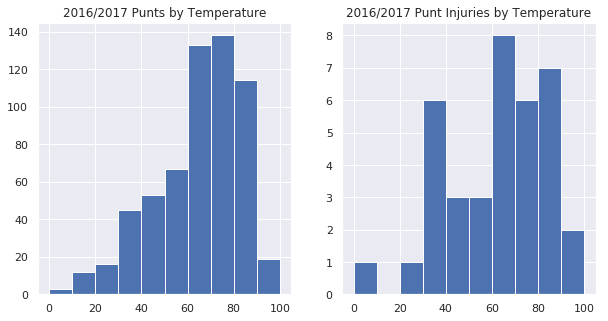

In [34]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hist(gamedata_df['Temperature'], range=(0,100))
plt.title('2016/2017 Punts by Temperature')

plt.subplot(1,2,2)
plt.hist(injury_games_df['Temperature'], range=(0,100))
plt.title('2016/2017 Punt Injuries by Temperature')

plt.show()

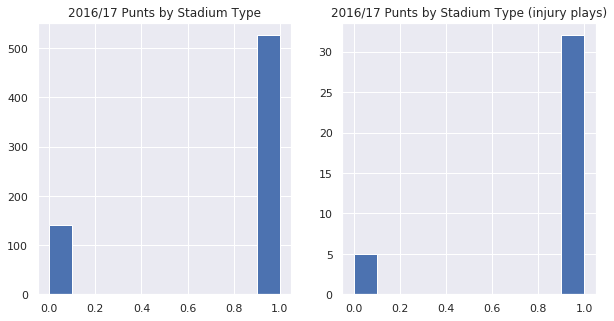

In [35]:
compare_hists(gamedata_df['stadium'], injury_games_df['stadium'], title1='Stadium Type', title2='Stadium Type (injury plays)')

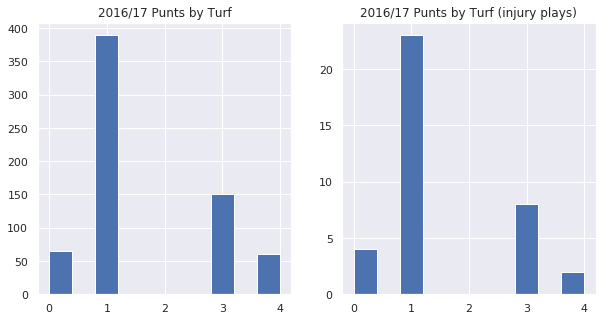

In [36]:
compare_hists(gamedata_df['turf'], injury_games_df['turf'], title1='Turf', title2='Turf (injury plays)')

In [38]:
#Perform T-Tests to determine the likelihood that the samples are representative of the same population
print('Temperature T-Test: {}'.format(ttest_ind(injury_games_df['Temperature'], gamedata_df['Temperature'], equal_var=False)))

Temperature T-Test: Ttest_indResult(statistic=nan, pvalue=nan)


From the above plots, it would appear that the weather, temperature, turf, and stadium type distributions on injury plays follow similar distributions to the set of all games during the 2016 and 2017 seasons. The only outlier appears to be the number of injuries that occurred between the temperatures 30 and 40 degrees Farhenheit. Of the just over 40 games that occurred in that temperature range, 6 were injury games. What is the likelihood of correlation?

## Question 2: Do concussions affect some roles more than others?

To answer this question, we will compare the distribution of roles among affected players to the total distribution of roles. We will also look at the role of the player whose contact caused the injury to look for patterns. Let's start by creating some new data frames.

In [42]:
#Import player role data by punt play into a Pandas Data Frame
plr_role_df = pd.read_csv('play_player_role_data.csv')

num_category(plr_role_df, 'Role', 'role')

#Create a Data Frame of just the players getting injured
prole_inj_df = pd.merge(plr_role_df, pd.read_csv('video_review.csv'), how='inner', on=['Season_Year', 'GameKey', 'PlayID', 'GSISID'])

#Fill NaN values with 'Unclear'
prole_inj_df.fillna('Unclear', inplace=True)

num_category(prole_inj_df, 'Player_Activity_Derived', 'activity')
num_category(prole_inj_df, 'Primary_Partner_Activity_Derived', 'partner_activity')
num_category(prole_inj_df, 'Primary_Impact_Type', 'impact')
num_category(prole_inj_df, 'Friendly_Fire', 'friendly_fire')

,Season_Year,GameKey,PlayID,GSISID,Role,role,Player_Activity_Derived,Turnover_Related,Primary_Impact_Type,Primary_Partner_GSISID,Primary_Partner_Activity_Derived,Friendly_Fire,activity,partner_activity,impact,friendly_fire
0,2017,384,183,33813,PPR,39,Tackling,No,Helmet-to-body,33841,Tackling,Yes,3,3,0,2
1,2017,448,2792,33838,PDR1,15,Blocking,No,Helmet-to-body,31317,Blocked,No,1,0,0,0
2,2016,266,2902,23564,PR,42,Tackled,No,Helmet-to-body,31844,Tackling,No,2,3,0,0
3,2016,274,3609,23742,P,6,Tackled,No,Helmet-to-helmet,31785,Tackling,No,2,3,2,0
4,2017,399,3312,26035,PR,42,Tackled,No,Helmet-to-body,27442,Tackling,No,2,3,0,0
5,2017,506,1988,27060,PR,42,Tackled,No,Helmet-to-helmet,Unclear,Tackling,No,2,3,2,0
6,2016,280,3746,27654,GL,0,Tackling,No,Helmet-to-helmet,33127,Tackled,No,3,2,2,0
7,2016,189,3509,27595,PR,42,Tackled,No,Helmet-to-helmet,31950,Tackling,No,2,3,2,0
8,2016,149,3663,28128,PFB,21,Blocking,No,Helmet-to-body,29629,Blocked,No,1,0,0,0
9,2016,234,3278,28620,PRG,43,Tackling,No,Helmet-to-body,27860,Tackled,No,3,2,0,0


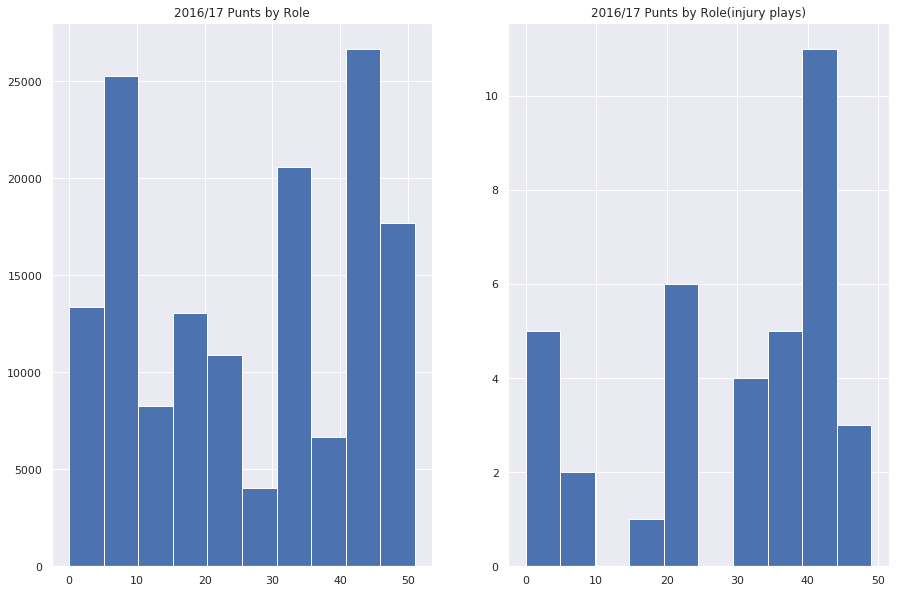

In [44]:
compare_hists(plr_role_df['role'], prole_inj_df['role'], title1='Role',
              title2='Role(injury plays)', figsize=(15,10))

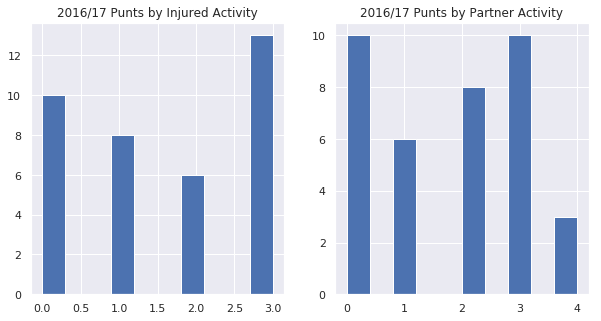

In [45]:
compare_hists(prole_inj_df['activity'], prole_inj_df['partner_activity'], title1='Injured Activity',
              title2='Partner Activity')

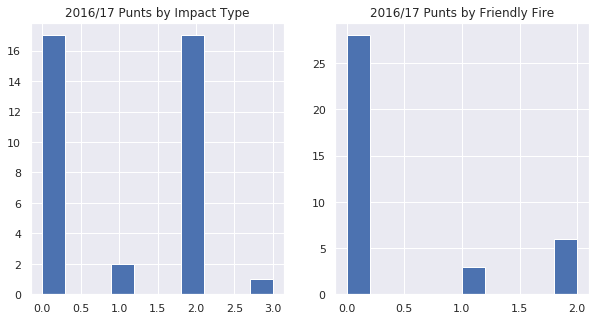

In [46]:
compare_hists(prole_inj_df['impact'], prole_inj_df['friendly_fire'], title1='Impact Type',
              title2='Friendly Fire')

In [47]:
#Create a Data Frame from select columns of the injury games Data Frame
pig_df = injury_games_df[['GameKey', 'Season_Year', 'Season_Type', 'Week', 'PlayID']]
pig_df.head()

,GameKey,Season_Year,Season_Type,Week,PlayID
0,5,2016,Pre,2,3129
1,21,2016,Pre,3,2587
2,29,2016,Pre,3,538
3,45,2016,Pre,4,1212
4,54,2016,Pre,5,1045


In [48]:
#Create a 2 dimensional array that holds the SeasonType, Week range, Season_Year,
#GameKey, and PlayID for each play to iterate through NGS files and select rows
pig_array = []
for index, row in pig_df.iterrows():
    st  = row['Season_Type'].lower()
    wk = row['Week']
    if st == 'reg':
        if wk <= 6:
            wk = '-wk1-6'
        elif 6 < wk <= 12:
            wk  = '-wk7-12'
        else:
            wk = '-wk13-17'
    else:
        wk = ''
    sy = str(row['Season_Year'])
    gk = str(row['GameKey'])
    pid = str(row['PlayID'])
    pig_array.append([st, wk, sy, gk, pid])

In [49]:
#Iterate through NGS files by injury producing to create an injury NGS Data Frane
#Set s as a StringIO object to hold lines from each file in memory to create a Data Frame
i = 0
s = StringIO()

for i in range(len(pig_array)):
    path = 'NGS-{}-{}{}.csv'.format(pig_array[i][2], pig_array[i][0], pig_array[i][1])
    start_seq = ','.join(pig_array[i][2:])

    with open(path) as f:
        for line in f:
            if i==0:
                s.write(line)
                i+=1
            elif line.startswith(start_seq):
                s.write(line)
        
s.seek(0)
ngs_df = pd.read_csv(s)
ngs_df.head()

,Season_Year,GameKey,PlayID,GSISID,Time,x,y,dis,o,dir,Event
0,2016,5,3129,31130.0,2016-08-12 02:07:26.300,80.540001,25.969999,0.06,137.669998,168.889999,NaN
1,2016,5,3129,28284.0,2016-08-12 02:07:26.300,79.599998,27.150000,0.05,191.940002,291.660004,NaN
2,2016,5,3129,31915.0,2016-08-12 02:07:26.300,80.750000,24.500000,0.01,160.529999,345.260010,NaN
3,2016,5,3129,31209.0,2016-08-12 02:07:26.300,79.540001,7.180000,0.02,169.179993,272.519989,NaN
4,2016,5,3129,28041.0,2016-08-12 02:07:26.300,80.269997,28.299999,0.02,137.050003,46.270000,NaN


In [50]:
# Set the index to the PlayID and don't drop
ngs_df.set_index(keys=['PlayID'], drop=False, inplace=True)
# Get a list of plays
plays = ngs_df['PlayID'].unique().tolist()
ngs_df.head()

,Season_Year,GameKey,PlayID,GSISID,Time,x,y,dis,o,dir,Event
PlayID,,,,,,,,,,,
3129,2016,5,3129,31130.0,2016-08-12 02:07:26.300,80.540001,25.969999,0.06,137.669998,168.889999,NaN
3129,2016,5,3129,28284.0,2016-08-12 02:07:26.300,79.599998,27.150000,0.05,191.940002,291.660004,NaN
3129,2016,5,3129,31915.0,2016-08-12 02:07:26.300,80.750000,24.500000,0.01,160.529999,345.260010,NaN
3129,2016,5,3129,31209.0,2016-08-12 02:07:26.300,79.540001,7.180000,0.02,169.179993,272.519989,NaN
3129,2016,5,3129,28041.0,2016-08-12 02:07:26.300,80.269997,28.299999,0.02,137.050003,46.270000,NaN


In [51]:
#Get stats for the first play
gm1 = ngs_df.loc[ngs_df.index==3129]
#gm1 = gm1.loc[gm1.GSISID==31057]
#min_tm = datetime.strptime(gm1['Time'].min(), %Y-%M-%d %H:%M:%S)
#gm1['Time'] = gm1[datetime.strptime(gm1['Time'], %Y-%M-%d %H:%M:%S) - min_tm]

#Parse the time as a datetime object and subject from the intial time to get elapsed time
min_tm = parser.parse(gm1['Time'].min())
gm1['Time'] = [parser.parse(time) - min_tm for time in gm1['Time']]


#gm1.sort_values(by='Time', axis=1, inplace=True)
gm1.tail()

/home/jeff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Season_Year,GameKey,PlayID,GSISID,Time,x,y,dis,o,dir,Event
PlayID,,,,,,,,,,,
3129,2016,5,3129,27718.0,00:00:18.300000,70.150002,15.05,0.56,187.259995,248.679993,punt_received
3129,2016,5,3129,32958.0,00:00:18.300000,43.150002,6.18,0.87,202.020004,293.019989,punt_received
3129,2016,5,3129,32477.0,00:00:18.300000,45.180000,6.05,0.77,193.199997,290.399994,punt_received
3129,2016,5,3129,32471.0,00:00:18.300000,69.430000,14.94,0.81,153.559998,257.100006,punt_received
3129,2016,5,3129,32136.0,00:00:18.300000,38.500000,23.65,0.92,169.520004,251.330002,punt_received


In [52]:
gm1 = gm1.sort_values(by='Time')

In [53]:
gm1.tail()

,Season_Year,GameKey,PlayID,GSISID,Time,x,y,dis,o,dir,Event
PlayID,,,,,,,,,,,
3129,2016,5,3129,31902.0,00:00:26.800000,42.730000,5.70,0.19,83.349998,139.919998,play_submit
3129,2016,5,3129,32776.0,00:00:26.800000,40.610001,4.89,0.11,155.190002,156.259995,play_submit
3129,2016,5,3129,26852.0,00:00:26.800000,47.799999,3.95,0.14,51.919998,161.229996,play_submit
3129,2016,5,3129,32519.0,00:00:26.800000,52.849998,11.95,0.13,163.470001,279.790009,play_submit
3129,2016,5,3129,31079.0,00:00:26.800000,51.779999,5.27,0.29,168.850006,257.609985,play_submit


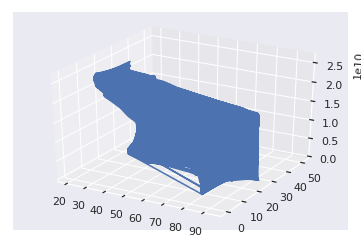

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

Axes3D.plot(ax, xs=gm1['x'], ys=gm1['y'], zs=gm1['Time'])

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 120), ylim=(0, 60))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = gm1['x'].iloc[i]
    y = gm1['y'].iloc[i]
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(gm1), interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('gm1_anim.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()